## Chapter 1 Introduction

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [100]:
def conduction_heat_flux(k, dT_dx) -> float:
    '''
    Solve for the conduction process heat transfer flux using the Fourier's Law of Heat Conduction
    
    Inputs:
    k               thermal conductivity (W/m/K)
    dT_dx           temperature gradient (K/m)

    Outputs:
    q_cond_flux     conduction process heat transfer flux (W/m^2)
    '''
    q_cond_flux = -k * dT_dx
    return q_cond_flux

def conduction_heat_rate(k, A_cross, L, T1, T2) -> float:
    '''
    Solve for the conduction process heat transfer rate using the Fourier's law of Heat Conduction
    
    Inputs:
    k               thermal conductivity (W/m/K)
    A               cross-sectional area (m^2)
    T1              temperature at one end of the material (K)
    T2              temperature at the other end of the material (K)
    L               length of the material (m)
    
    Outputs:
    q_cond_rate    conduction process heat transfer rate (W)
    '''

    q_cond_rate = k * A_cross * (T1 - T2) / L
    return q_cond_rate

def convection_heat_flux(h, T_s, T_inf) -> float:
    '''
    Solve for the convection process heat transfer flux using Newton's law of cooling

    Inputs:
    h               convective heat transfer coefficient
    T_s             temperature of controlled surface (K)
    T_inf           temperature of bulk fluid flowing around the surface (K)

    Outputs:
    q_conv_flux     convective heat transfer flux (W/m^2)
    '''

    q_conv_flux = h * (T_s - T_inf)
    return q_conv_flux

def convection_heat_rate(h, A_cross, L, T_surface, T_inf) -> float:
    '''
    Solve for the convection process heat transfer rate using Newton's law of cooling

    Inputs:
    h               convective heat transfer coefficient (W/m^2/K)
    A_cross         cross-sectional area (m^2)
    L               length of the material (m)
    T_s             temperature of controlled surface (K)
    T_inf           temperature of bulk fluid flowing around the surface (K)

    Outputs:
    q_conv_rate    convective process heat transfer rate (W)
    '''

    q_conv_rate = h * A_cross * L * (T_surface - T_inf)
    return q_conv_rate

def convection_T_surface(q_conv_rate, coeff_conv, Area_cross, L, T_inf) -> float:
    '''
    Solve for the convection process surface temperature using Newton's law of cooling

    Inputs:
    q_conv_rate     convective heat transfer rate (W/m^2)
    h               convective heat transfer coefficient (W/m^2/K)
    T_inf           temperature of bulk fluid flowing around the surface (K)
    A_cross         cross-sectional area (m^2)
    L               length of the material (m)
    
    Outputs:
    t_surface       temperature of controlled surface (K)
    '''

    t_surface = (q_conv_rate / (coeff_conv * Area_cross)) + T_inf
    return t_surface

def radiation_heat_flux(epsilon, T_s, T_sur) -> float:
    '''
    Solve for the radiation process heat transfer flux using Stefan-Boltzmann law  of radiation
    Assuming a black body radiation of a small body inside a large compartment
    
    Inputs:
    epsilon         control surface emissive property
    T_s             temperature of controlled surface (K)
    T_sur           temperature of large surface surrounding the small surface (K)
    '''

    sigma = 5.67*10**-8        # Stefan-Boltzmann constant (W/m^2/K^4)
    q_rad_flux   = sigma * epsilon * (T_s**4 - T_sur**4)
    return q_rad_flux

def radiation_heat_rate(epsilon, A_cross, L, T_s, T_sur) -> float:
    '''
    Solve for the radiation process heat transfer rate using Stefan-Boltzmann law of radiation
    Assuming a black body radiation of a small body inside a large compartment
    
    Inputs:
    epsilon         control surface emissive property
    A_cross         cross-sectional area (m^2)
    L               length of the material (m)
    T_s             temperature of controlled surface (K)
    T_sur           temperature of large surface surrounding the small surface (K)

    Outputs:
    q_rad_rate     radiation process heat transfer rate (W)
    '''

    sigma = 5.67*10**-8        # Stefan-Boltzmann constant (W/m^2/K^4)
    q_rad_rate = sigma * epsilon * A_cross * L * (T_s**4 - T_sur**4)
    return q_rad_rate

def radiation_T_surface(q_flux_rad, emissivity, T_s, T_sur, A_cross, L) -> float:
    '''
    Solve for the radiation process surface temperature using Stefan-Boltzmann equation

    Inputs:
    q_flux_rad      radiation heat transfer flux
    emissivity      control surface emissive property, assumed to equate the absobtivity property
    T_s             temperature of controlled surface (K)
    T_sur           temperature of large surface surrounding the small surface (K)
    A_cross         cross-sectional area (m^2)
    L               length of the material (m)

    Outputs:
    t_surface       temperature of controlled surface (K)
    '''

    sigma = 5.67*10^-8 # Stefan-Boltzmann constant (W/m^2/K^4)
    T_s = (q_flux_rad / (sigma * emissivity * A_cross * L) + T_sur**4)**(1/4)
    return T_s


In [101]:
'''
Solve a simpler case of Example 4, where there is no heat generation
'''
# Assume there is no heat generation

# Rod dimensions:
rod_diameter    = 0.001     # meters
rod_length      = 0.5       # meters
rod_cross_area  = np.pi*(rod_diameter/2)**2  # cross-sectional area in m^2
rod_volume      = rod_cross_area * rod_length

# Rod material properties:
rod_density         = 7800  # kg/m^3 (steel)
rod_mass            = rod_density * rod_volume  # mass in kg
rod_specific_heat   = 500   # J/(kg*K) (steel)

# Environment convection
T_inf               = 300       # K (ambient temperature)
contective_coeff    = 100       # W/(m^2*K) (convection heat transfer coefficient)

# Environment radiation
t_large_surface     = 300       # K (temperature of the large surface area)
emissivity          = 0.8       # emissivity of the rod surface
sigma               = 5.67e-8   # W/(m^2*K^4) (Stefan-Boltzmann constant)


# Case 1: No heat generation due to electricity, t_fluid and t_surf needed to solve the ODE    
# Heat transfer due to convection and radiation
def dT_dt_solver(t_surf, time):
    ''' 
    This function assumes that the rod is not generating heat, and only convective and radiative heat transfer are considered.
    Sove the ODE for the temperature change rate of the rod surfacce
    Inputs:
    t_surf  temperature of the rod surface (K)
    
    Outputs:
    dT/dt   rate of change of temperature with respect to time (K/s)
    '''
    return (-np.pi*rod_diameter*contective_coeff*(t_surf - T_inf) - np.pi*rod_diameter*emissivity*sigma*(t_surf**4 - t_large_surface**4)) / (rod_density*rod_specific_heat*np.pi*rod_diameter**2/4)

# Case 2: heat generation due to electricity
# Energy gen - Electrical power
current             = 8         # I (current through rod)
resistance_per_L    = 0.4       # Ohms (resistance of the rod)
energy_gen_per_L    = current**2 * resistance_per_L    # W (power generated by rod) per unit length
def dT_dt_solver_with_gen(t_surf, time):
    '''
    This function assumes that the rod is generating heat due to electrical current, and only convective and radiative heat transfer are considered.
    Solve the ODE for the temperature change rate of the rod surface
    Inputs:
    t_surf  temperature of the rod surface (K)
    Outputs:
    dT/dt   rate of change of temperature with respect to time (K/s)
    '''
    return (energy_gen_per_L - np.pi*rod_diameter*contective_coeff*(t_surf - T_inf) - np.pi*rod_diameter*emissivity*sigma*(t_surf**4 - t_large_surface**4))/(rod_density*rod_specific_heat*np.pi*rod_diameter**2/4)


375.9953549037402


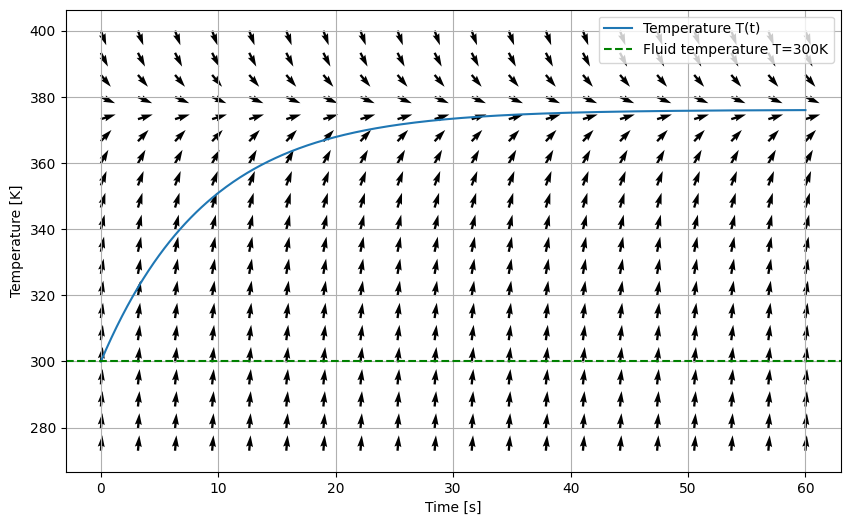

In [102]:
# Compute dT/dt
time_max        = 60
grid_time       = np.linspace(0,time_max,20)
grid_t_surf     = np.linspace(273,400,20)
grid_t_surf, grid_time = np.meshgrid(grid_t_surf, grid_time)
dT_dt           = dT_dt_solver_with_gen(grid_t_surf, grid_time)
 
# Normalize vectors
u = 1
v = dT_dt
magnitude = np.sqrt(u**2 + v**2)
u_norm = u / magnitude  
v_norm = v / magnitude

# Get a particular solution for the ODE
t_solver    = np.linspace(0, time_max, 400)
t_surf0     = 300       # Initial condition
#t_surf_sol  = odeint(dT_dt_solver, y0=t_surf0, t=t_solver)
t_surf_sol  = odeint(dT_dt_solver_with_gen, y0=t_surf0, t=t_solver)

t_surf_sol.T[0]
print(max(t_surf_sol[-1]))

# Plot vector field
plt.figure(figsize=(10,6))
plt.plot(t_solver, t_surf_sol,label='Temperature T(t)')

plt.axhline(y=T_inf, color='green', linestyle='--', label=f'Fluid temperature T={T_inf}K')

plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]')
plt.quiver(grid_time, grid_t_surf, u_norm, v_norm, scale=50)
plt.grid(True)
plt.legend()
plt.show()

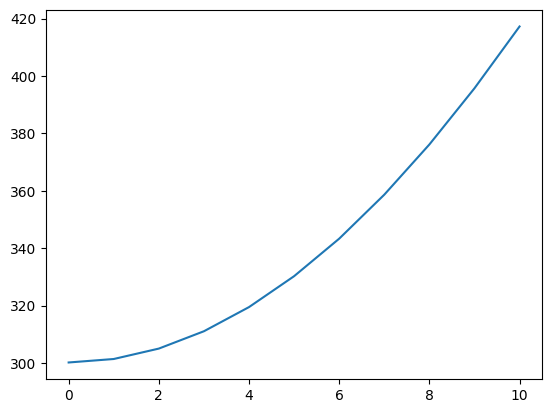

In [103]:
curr_list = [0, 1, 2, 3, 4, 5, 6, 7, 8 , 9, 10]
t_list = [300.15, 301.36, 304.99, 311.03, 319.45, 330.22, 343.29, 358.62, 376.11, 395.69, 417.23]
plt.plot(curr_list, t_list);

In [104]:
# Modified secant method
def modified_secant(f_x, target_f_x, x_0, f_x_params=None, dx=0.01, error_stop_criterion=1e-10, iter_max=500):
    '''
    Iterate to find the x value that corresponds to when f_x is equal to a target_f_x value
    Assumes there is only one root
    
    Inputs:
    f                   function to find the roots
    x_0                 initial guess
    dx                  perturbation parameter for modified secant method
    error_criterion     iteration error must be below error_criterion to end computation
    iter_max            maximum number of iterations allowed above which computation ends
    '''
    # Initial iteration values
    i = 0               
    x_i             = x_0
    if f_x_params == None:
        f_i = f_x(x_i) - target_f_x
    else:
        f_i = f_x(x_i, f_x_params) - target_f_x

    error_i         = None
    
    # Create dataframe to record iteration values
    dict_iter    = {'Iteration': [i], 'x_i':[x_i], 'f_i':[f_i], 'error_i':[error_i]}
    df_iter      = pd.DataFrame(dict_iter).set_index('Iteration')

    while (error_i == None) or (error_i > error_stop_criterion):        
        # Compute new estimate
        if f_x_params == None:    
            f_dx_i          = f_x(x_i+dx) - target_f_x
        else:
            f_dx_i          = f_x(x_i+dx, f_x_params) - target_f_x

        f_deriv_i       = (f_dx_i - f_i) / dx
        x_i_new         = x_i - f_i/f_deriv_i 
        
        if f_x_params == None:    
            f_i_new         = f_x(x_i_new) - target_f_x
        else:
            f_i_new         = f_x(x_i_new, f_x_params) - target_f_x

        error_i_new     = abs((x_i_new - x_i)/x_i_new)

        # Set and check the next iteration number
        if i == iter_max:   
            print('stopped due to iteration max')
            break
        
        # Set the next iteration x_i and f_i values
        i+=1
        x_i     = x_i_new
        f_i     = f_i_new
        error_i = error_i_new
        df_iter.loc[len(df_iter)] = [x_i, f_i+target_f_x, error_i]

    # Display the dataframe of iteration
    return x_i, f_i+target_f_x, error_i, df_iter

307.32923942512144


C:\Users\luis1\AppData\Local\Temp\ipykernel_14268\3529695417.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iter.loc[len(df_iter)] = [x_i, f_i+target_f_x, error_i]


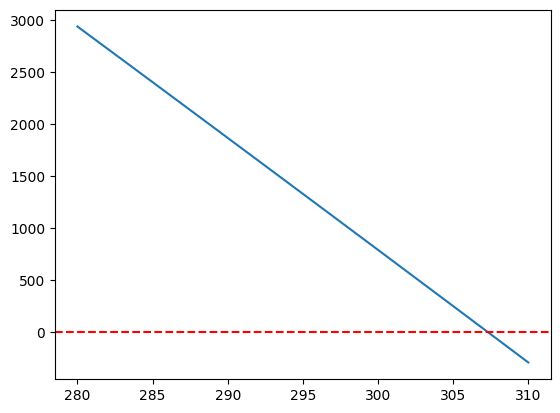

In [105]:
# Based on Example 1.6
# Human skin surface energy balance

#t_core = 37+273.15          # K (core temperature of human body)
t_skin_inner = 35+273.15    # K (inner skin surface temperature)
l = 0.003                   # m (skin/fat layer)
k = 0.3                     # W/mK (effective thermal conductivity)
surf_area = 1.8             # m**2 (person surface area)
emissivity = 0.95           # (surface emissivity constant)
T_sur = 297        # K (temperature of large surface surroundings)

# Case 1: person surrounding by air at t_fluid = 297K and h=2W/n2/K
t_air = 297
h = 2                       # W/m2/K 
# equation solved manually:
# k * (Ti-Ts) / L = h*(Ts-Tinf) + epsilon*sigma*(Ts**4 - Tsurf**4)
# set the left side equal to zero:
# 0 = k * (Ti-Ts) / L - h*(Ts-Tinf) - epsilon*sigma*(Ts**4 - Tsurf**4)

# Can't solve this function explicitly
# Therefore, create a function and find the zeros of this function to obtain implict Ts values
# f(Ts) = 0 = k * (Ti-Ts) / L - h*(Ts-Tinf) - epsilon*sigma*(Ts**4 - Tsurf**4)

def t_skin_surf(t_surf):
 return k * (t_skin_inner-t_surf) / l - h*(t_surf-t_air) - emissivity*sigma*(t_surf**4 - T_sur**4)

t_surf_secant, f_zero_secant, error, df =  modified_secant(f_x=t_skin_surf, target_f_x=0, x_0=273)

print(t_surf_secant)

# Idea! Plot the function first :)
t_surf          = np.linspace(280, 310, 100)
f_zero_t_surf   = k*(t_skin_inner-t_surf)/l - h*(t_surf-t_air) - emissivity*sigma*(t_surf**4 - T_sur**4)

# value seems to be around 307K = 34C
plt.plot(t_surf, f_zero_t_surf)
plt.axhline(y=0, color='red', linestyle='--', label=f'Modifiled secant solution when f(t_surf)=0K')
plt.show();


In [106]:
import matplotlib.pyplot as plt

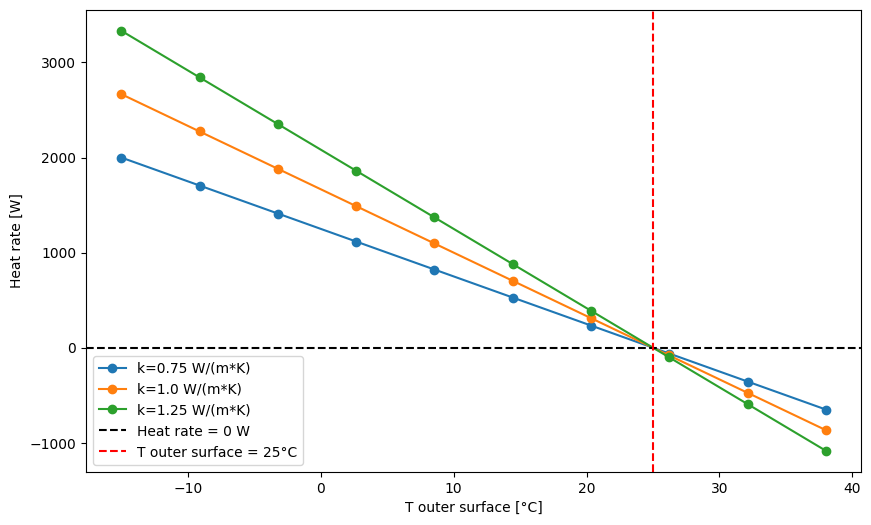

In [107]:
# Problem 1.3

t1 = 25 # °C
l  = 0.3 # m 
a  = 20  #m^2

# Use Fourier's law for a range of temperatures of interest -15°C to 38°C 
# Temperatures kept with °C, instead of Kelvin, since the delta in temprarures is used in Fourier's law
t0      = np.linspace(-15,38,10)
df      = pd.DataFrame({'T outer surface [°C]':t0})
k_arr   = np.array([.75,1,1.25])        # List of thermal conductivities of interest for comparison

# Create a Heat rate column for each conductivity value of interest 
for k in k_arr:
    df[f'Heat rate [W] @k={k}'] = k *a * (t1 - t0) / l

# Plot the results
plt.figure(figsize=(10,6))
for k in k_arr:
    plt.plot(t0, df[f'Heat rate [W] @k={k}'], label=f'k={k} W/(m*K)', marker='o')
plt.xlabel('T outer surface [°C]')
plt.ylabel('Heat rate [W]') 
plt.axhline(y=0, color='black', linestyle='--', label='Heat rate = 0 W');
plt.axvline(x=25, color='red', linestyle='--', label=f'T outer surface = {t1}°C');
plt.legend(loc='lower left');

# Problem notes
# Heat rate vareies linearly with conductivity coefficient k
# Heat rate is zero when the outer surface is equal to the inner surface temperature maintained at 25°C
# During winter (T < 25°C), heat rate is negative, meaning heat is lost to the environment
# During summer (T > 25°C), heat rate is positive, meaning heat is gained from the environment


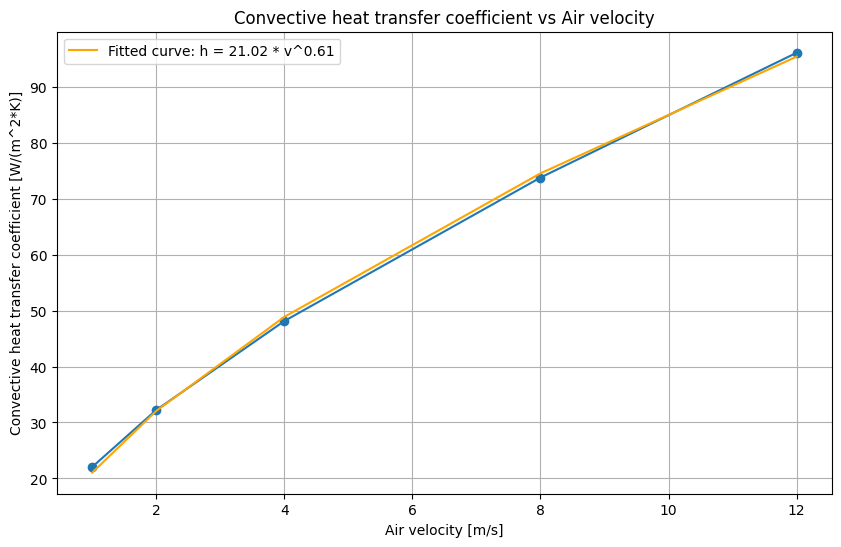

,Air velocity [m/s],Power per unit length [W/m],h [W/(m^2*K)]
0,1,450,22.036838
1,2,658,32.222755
2,4,983,48.138249
3,8,1507,73.798923
4,12,1963,96.129586


In [108]:
# Problem 1.19 
# Rod with electrical heater to determine convection heat transfer coefficient
Tinf    = 40            # °C
d       = 0.025         # m (diameter of rod)
a_rod_per_L = np.pi * d # m^2 (cross-sectional area of rod per unit length)
T_s     = 300           # °C (surface temperature of rod) maintained by electrical heater

air_vel     = np.array([1,2,4,8,12])                    # m/s (air velocity around the rod)
Power_per_L = np.array([450,658,983,1507,1963])    # W/m (power per unit length of rod)

df = pd.DataFrame({'Air velocity [m/s]': air_vel, 'Power per unit length [W/m]': Power_per_L})
df['h [W/(m^2*K)]'] = Power_per_L / (a_rod_per_L * (T_s - Tinf))
# Plot the results
plt.figure(figsize=(10,6))
plt.plot(df['Air velocity [m/s]'], df['h [W/(m^2*K)]'], marker='o')
plt.xlabel('Air velocity [m/s]')
plt.ylabel('Convective heat transfer coefficient [W/(m^2*K)]')
plt.title('Convective heat transfer coefficient vs Air velocity')

# Obtain the power correlation between air velocity and heat transfer coefficient 
from scipy.optimize import curve_fit
def power_law(x, a, b):
    '''
    Power law function for curve fitting
    Inputs:
    x   independent variable (air velocity)
    a   coefficient
    b   exponent
    Outputs:
    y   dependent variable (heat transfer coefficient)
    '''
    return a * x**b

# Fit the power law to the data
params, _   = curve_fit(power_law, df['Air velocity [m/s]'], df['h [W/(m^2*K)]'])
# Generate fitted values
fitted_h    = power_law(df['Air velocity [m/s]'], *params)

# Plot the fitted curve
plt.plot(df['Air velocity [m/s]'], fitted_h, label=f'Fitted curve: h = {params[0]:.2f} * v^{params[1]:.2f}', color='orange')
plt.legend()
plt.grid(True)
plt.show()
df
# Air convective heat transfer coefficient is proportional to air velocity to the power of 0.61

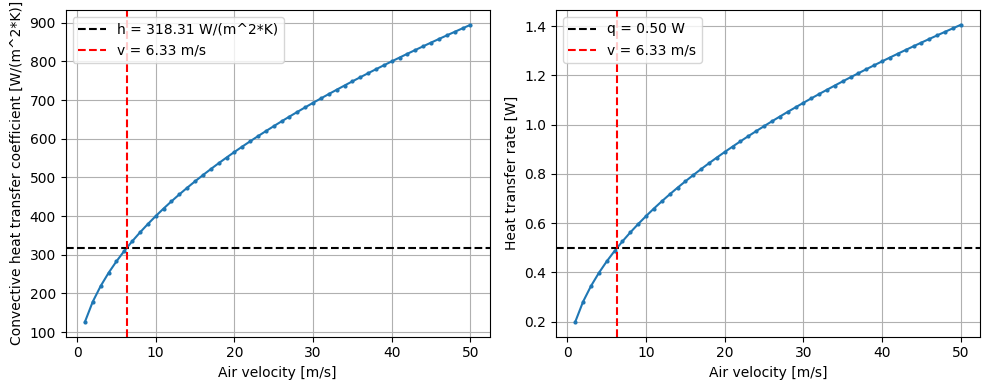

In [109]:
# Problem 1.25
# Hot wire anemometer (HWA) to measure air velocity by keeping the wire at a constant surface temperature
# The wire is heated by an electrical current, and heat is lost to the air by forced convection

# Electrical wire 
l = 0.020   # m (length of wire)
d = 0.0005  # m (diameter of wire)

# Electrical power
V = 5.0    # V (voltage applied to the wire)
i = 0.1    # A (current through the wire)
p = V*i     # W (power generated by the wire)


# Heat transfer system
T_inf = 25 # °C (ambient temperature)
T_s   = 75 # °C (surface temperature of wire) Maintained constant by the electrical current

# Single solution for the convective heat transfer coefficient
h_solution = p / (np.pi * d * l * (T_s - T_inf))  # W/(m^2*K)
# v = 6.25 * 10^-5 * h^2
v_solution = 6.25 * 10**-5 * h_solution**2  # m/s (air velocity corresponding to the convective heat transfer coefficient)

# Calibration for HWA
v = np.arange(1, 51, 1)  # m/s (air velocity range for calibration)
h = (v / (6.25e-5))**0.5     # W/(m^2*K) 

df = pd.DataFrame({'Air velocity [m/s]': v, 'Convective heat transfer coefficient [W/m^2/K]': h})
df['Heat transfer rate [W]'] = h * np.pi * d * l * (T_s - T_inf)  # Heat transfer rate from the wire surface to the air

# Plot the convective heat transfer coefficient vs air velocity
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 4)); # Adjust figsize as needed
# Plot the convective heat transfer coefficient vs air velocity
ax1.plot(df['Air velocity [m/s]'], df['Convective heat transfer coefficient [W/m^2/K]'], marker='o', markersize=2)
ax1.set_xlabel('Air velocity [m/s]')
ax1.set_ylabel('Convective heat transfer coefficient [W/(m^2*K)]')
ax1.axhline(y=h_solution, color='black', linestyle='--', label='h = {:.2f} W/(m^2*K)'.format(h_solution))
ax1.axvline(x=v_solution, color='red', linestyle='--', label='v = {:.2f} m/s'.format(v_solution))
ax1.grid(True)
ax1.legend(loc='upper left')

# Plot the heat transfer rate vs air velocity
ax2.plot(df['Air velocity [m/s]'], df['Heat transfer rate [W]'], marker='o', markersize=2)
ax2.set_xlabel('Air velocity [m/s]')
ax2.set_ylabel('Heat transfer rate [W]')
ax2.axhline(y=p, color='black', linestyle='--', label='q = {:.2f} W'.format(p))
ax2.axvline(x=v_solution, color='red', linestyle='--', label='v = {:.2f} m/s'.format(v_solution))
ax2.grid(True)
ax2.legend(loc='upper left')
plt.tight_layout()
plt.show();


# For a system with constan area and temperature difference,
#  increasing the airflow velocity by 100% increases the convective heat transfer coefficient and heat transfer rate by 41%
#  increasing the airflow velocity by a factor of 2 increases the convective heat transfer coefficient and heat transfer rate by a factor of 1.41


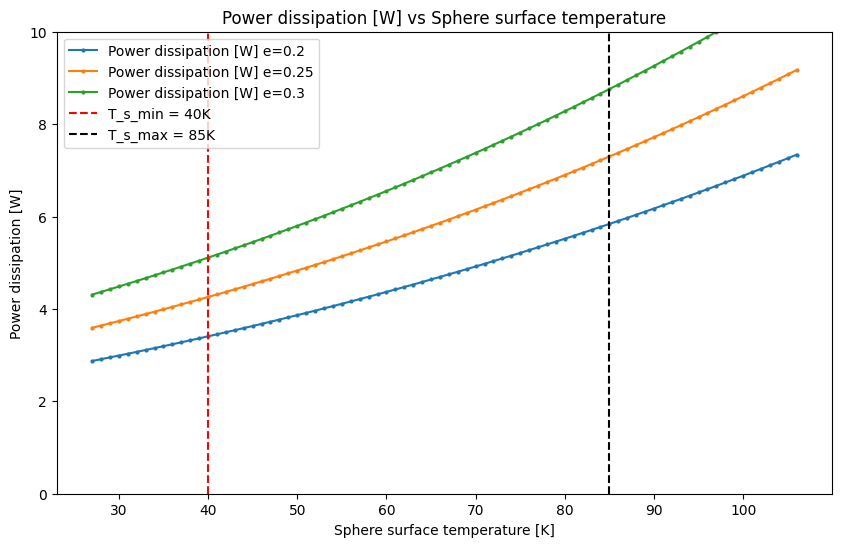

In [134]:
# Problem 1.31
# Sphere instrumentation
sigma = 5.67*10**-8  # W/(m^2*K^4) (Stefan-Boltzmann constant)

# Sphere dimensions
d = 0.1  # m (diameter of sphere)
a = np.pi * d**2  # m^2 (suraface area of sphere)

# Sphere properties
e1 = 0.20 # emissivity of sphere surface
e2 = 0.25 
e3 = 0.30 

T_s_min = 313  # K (minimum surface temperature of sphere)
T_s_max = 358  # K (maximum surface temperature of sphere)
T_s = np.arange(300, 380, 1, dtype=np.float32) # K deired surface temperatures of the sphere
T_s_C = T_s - 273  # Convert to Celsius for plotting

# System
T_sur = 77     # K (temperature of large surface surrounding the sphere)
q_rad1 = e1 * sigma * a * (T_s**4 - T_sur**4)  # W (radiative heat transfer rate from the sphere surface to the large surface)
q_rad2 = e2 * sigma * a * (T_s**4 - T_sur**4)  # W (radiative heat transfer rate from the sphere surface to the large surface)
q_rad3 = e3 * sigma * a * (T_s**4 - T_sur**4)  # W (radiative heat transfer rate from the sphere surface to the large surface)

# Plot the results
plt.figure(figsize=(10,6))

plt.plot(T_s_C, q_rad1, marker='o', markersize=2, label=f'Power dissipation [W] e={e1}')
plt.plot(T_s_C, q_rad2, marker='o', markersize=2, label=f'Power dissipation [W] e={e2}')
plt.plot(T_s_C, q_rad3, marker='o', markersize=2, label=f'Power dissipation [W] e={e3}')

plt.xlabel('Sphere surface temperature [K]')
plt.ylabel('Power dissipation [W]')
plt.ylim(0, 10)  # Set y-axis limits for better visibility
plt.title('Power dissipation [W] vs Sphere surface temperature')
plt.axvline(x=T_s_min-273, color='r', linestyle='--', label=f'T_s_min = {T_s_min-273}K')
plt.axvline(x=T_s_max-273, color='k',   linestyle='--', label=f'T_s_max = {T_s_max-273}K')
plt.legend(loc='upper left')
plt.show();

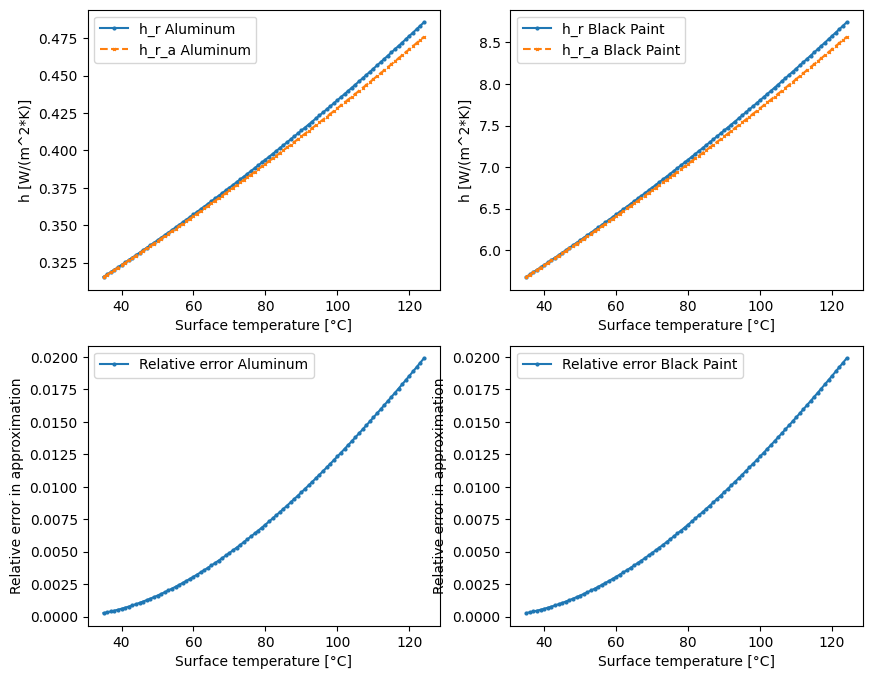

In [ ]:
# Problem 1.33
# Approximation of convective heat transfer for small differences in temperatures Ts and Tsur

# Original    h_r   = epsilon * sigma * (Ts + Tsur) * (Ts**2 + Tsur**2)
# Apprximated h_r_a = 4 * epsilon * sigma * Tavg**3
# Tavg = (Ts + Tsur) / 2

# Case 1: 
epsilon_aluminum    = 0.05
epsilon_black_paint = 0.9
T_sur = 298          # K (temperature of large surface surrounding the small surface)
T_s = np.arange(298+10, 298+100, 1, dtype=np.float32)  # K (temperature of controlled surface)

# Actual
h_r_aluminum    = epsilon_aluminum    * sigma * (T_s + T_sur) * (T_s**2 + T_sur**2)  # W/(m^2*K) (radiative heat transfer coefficient)
h_r_black_paint = epsilon_black_paint * sigma * (T_s + T_sur) * (T_s**2 + T_sur**2)  # W/(m^2*K) (radiative heat transfer coefficient)

# Approximation
T_avg = (T_s + T_sur) / 2  # K (average temperature)
h_r_a_aluminum      = 4 * epsilon_aluminum    * sigma * T_avg**3  # W/(m^2*K) (approximated radiative heat transfer coefficient)
h_r_a_black_paint   = 4 * epsilon_black_paint * sigma * T_avg**3  # W/(m^2*K) (approximated radiative heat transfer coefficient)

# errors
error_h_r_aluminum      = (h_r_aluminum - h_r_a_aluminum)   / h_r_aluminum          # (relative error in approximation)
error_h_r_black_paint   = (h_r_black_paint - h_r_a_black_paint) / h_r_black_paint   # (relative error in approximation))

# Plot the results
# Plot the convective heat transfer coefficient vs air velocity
fig, (ax_top, ax_bot) = plt.subplots(2, 2, sharey=False, figsize=(10, 8)); # Adjust figsize as needed
ax_top[0].plot(T_s-273, h_r_aluminum,     label='h_r Aluminum',   marker='o', markersize=2)
ax_top[0].plot(T_s-273, h_r_a_aluminum,   label='h_r_a Aluminum', linestyle='--', marker='x', markersize=2)
ax_top[0].set_xlabel('Surface temperature [°C]')  
ax_top[0].set_ylabel('h [W/(m^2*K)]')
ax_top[0].legend(loc='upper left')
# Plot the relative error in approximation
ax_bot[0].plot(T_s-273, error_h_r_aluminum, label='Relative error Aluminum', marker='o', markersize=2)
ax_bot[0].set_xlabel('Surface temperature [°C]')    
ax_bot[0].set_ylabel('Relative error in approximation')
ax_bot[0].legend(loc='upper left')

# Black paint analysis
ax_top[1].plot(T_s-273, h_r_black_paint,   label='h_r Black Paint',   marker='o', markersize=2)
ax_top[1].plot(T_s-273, h_r_a_black_paint, label='h_r_a Black Paint', linestyle='--', marker='x', markersize=2)
ax_top[1].set_xlabel('Surface temperature [°C]')
ax_top[1].set_ylabel('h [W/(m^2*K)]')
ax_top[1].legend(loc='upper left')
ax_bot[1].plot(T_s-273, error_h_r_black_paint, label='Relative error Black Paint', marker='o', markersize=2)
ax_bot[1].set_xlabel('Surface temperature [°C]')
ax_bot[1].set_ylabel('Relative error in approximation')
ax_bot[1].legend(loc='upper left')

plt.show()
# Approximated heat transfer coeffiient understimates the actual heat transfer coefficient for both materials